In [21]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
from scipy import stats
import seaborn as sns

In [2]:
chapters = pd.read_json("book_chapters_w_NER.jl", lines=True)

In [3]:
from textblob import TextBlob

In [4]:
%%time
chapt_sent = chapters["chapt_text"].apply(lambda x: TextBlob(x).sentiment)

CPU times: total: 17.6 s
Wall time: 17.7 s


In [5]:
chapters["chapt_pol"], chapters["chapt_subj"] = zip(*chapt_sent) # making 2 new cols with polarity and subjectivity

In [6]:
chapters.to_json("book_chapters_w_NER_sent.jl", orient="records", lines=True)

In [7]:
comments = pd.read_json("comments_w_NER.jl", lines=True)

In [8]:
%%time
comment_sent = comments["comment_text"].apply(lambda x: TextBlob(x).sentiment)

CPU times: total: 32.4 s
Wall time: 32.6 s


In [9]:
comments["comment_pol"], comments["comment_subj"] = zip(*comment_sent) # making 2 new cols with polarity and subjectivity

In [10]:
comments.to_json("comments_w_NER_sent.jl", orient="records", lines=True)

### Looking at trends in Chapter Sentiment

#### Mean Sentiment per book

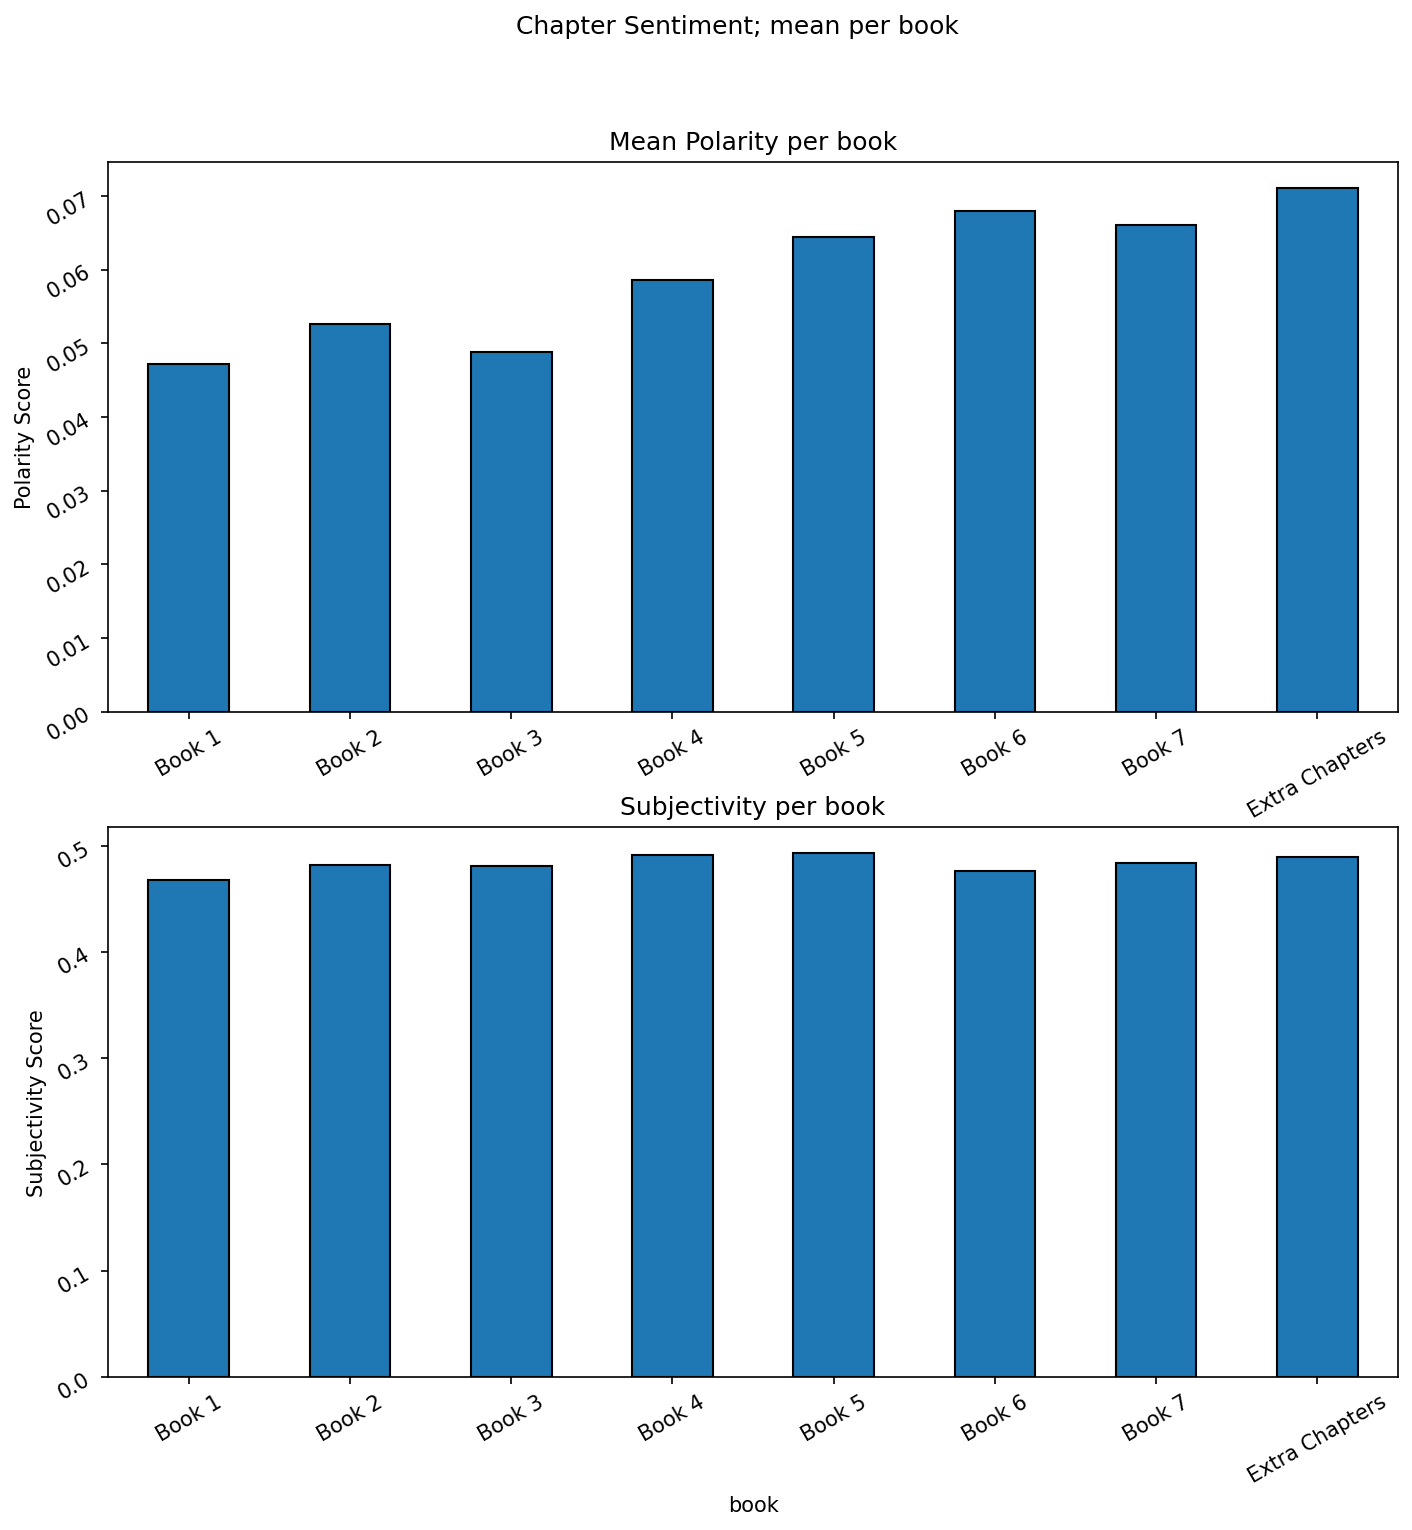

In [101]:

# this is an opportunity for us to go ahead and make some subplots
fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.suptitle("Chapter Sentiment; mean per book")
fig.tight_layout(pad=3.5)


chapters.groupby("book")["chapt_pol"].mean().plot(kind="bar", edgecolor="black", ax=ax[0])
ax[0].set_title("Mean Polarity per book")
ax[0].tick_params(labelrotation=30)
ax[0].set_ylabel("Polarity Score")

chapters.groupby("book")["chapt_subj"].mean().plot(kind="bar", edgecolor="black", ax=ax[1])
ax[1].set_title("Subjectivity per book")
ax[1].tick_params(labelrotation=30)
ax[1].set_ylabel("Subjectivity Score")

plt.show()

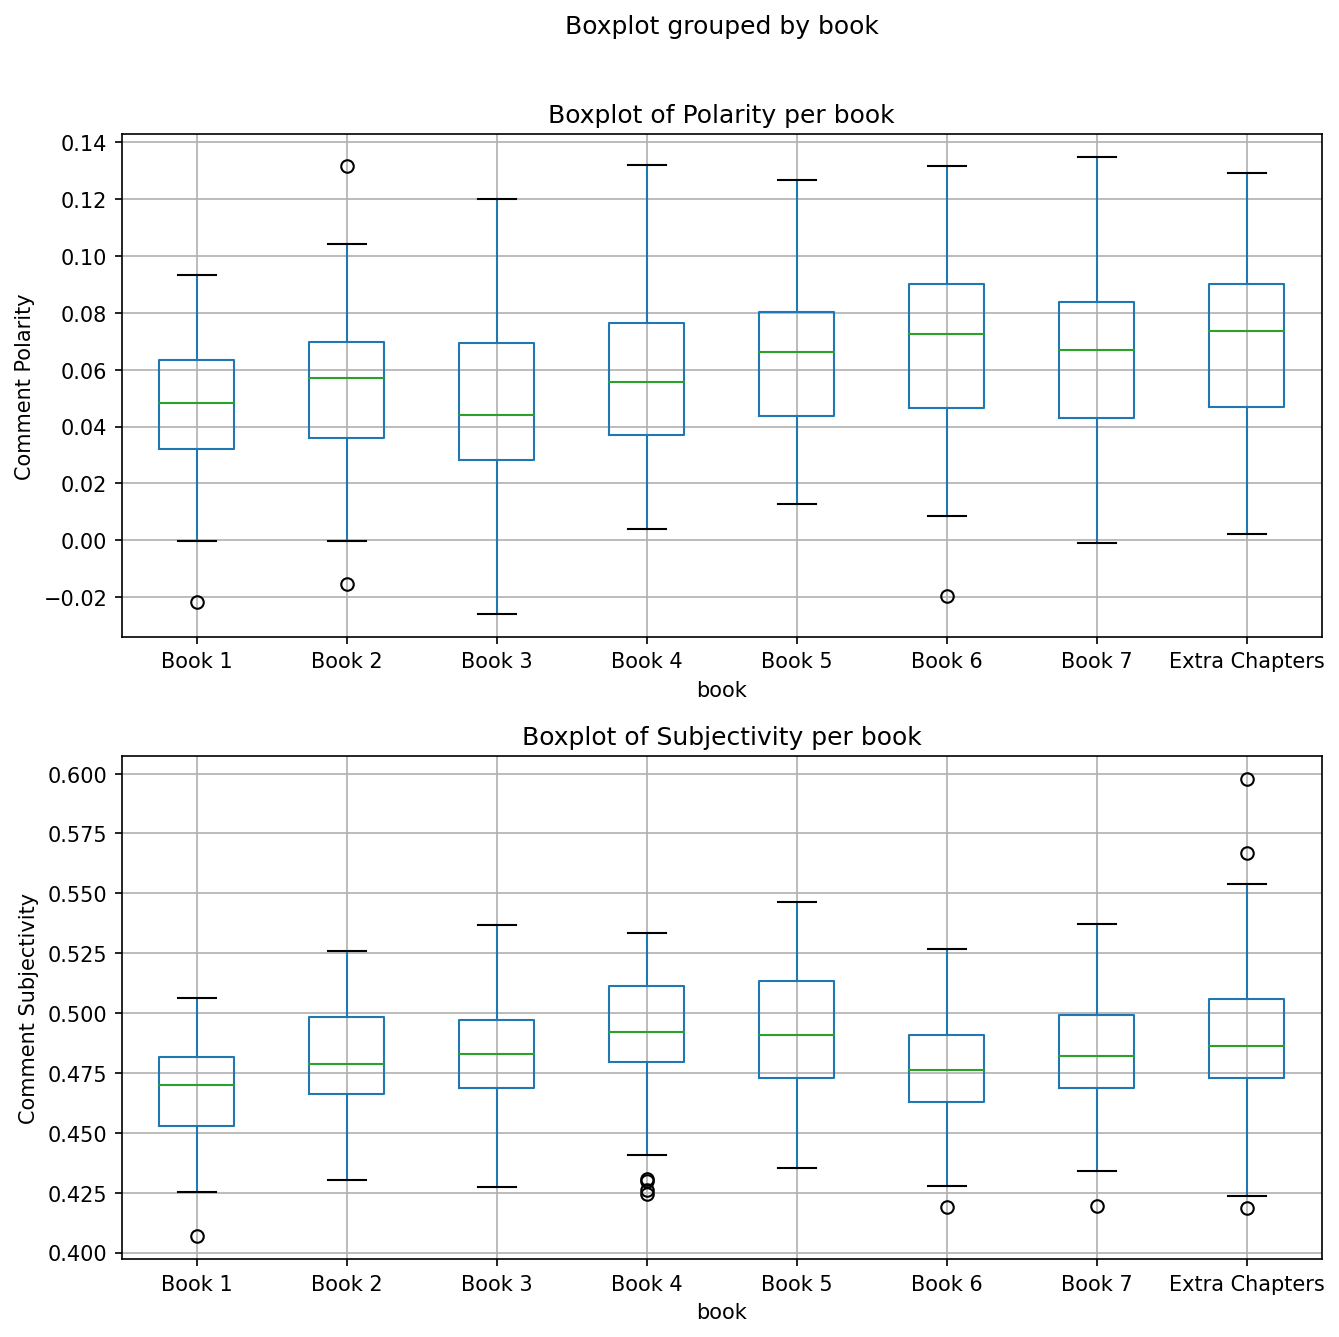

In [102]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
fig.suptitle("Sentiment by book")
fig.tight_layout(pad=4)

chapters.boxplot(by="book",column="chapt_pol", ax=ax[0])
ax[0].set_title("Boxplot of Polarity per book")
ax[0].set_ylabel("Comment Polarity")

chapters.boxplot(by="book",column="chapt_subj", ax=ax[1])
ax[1].set_title("Boxplot of Subjectivity per book")
ax[1].set_ylabel("Comment Subjectivity")

plt.show()

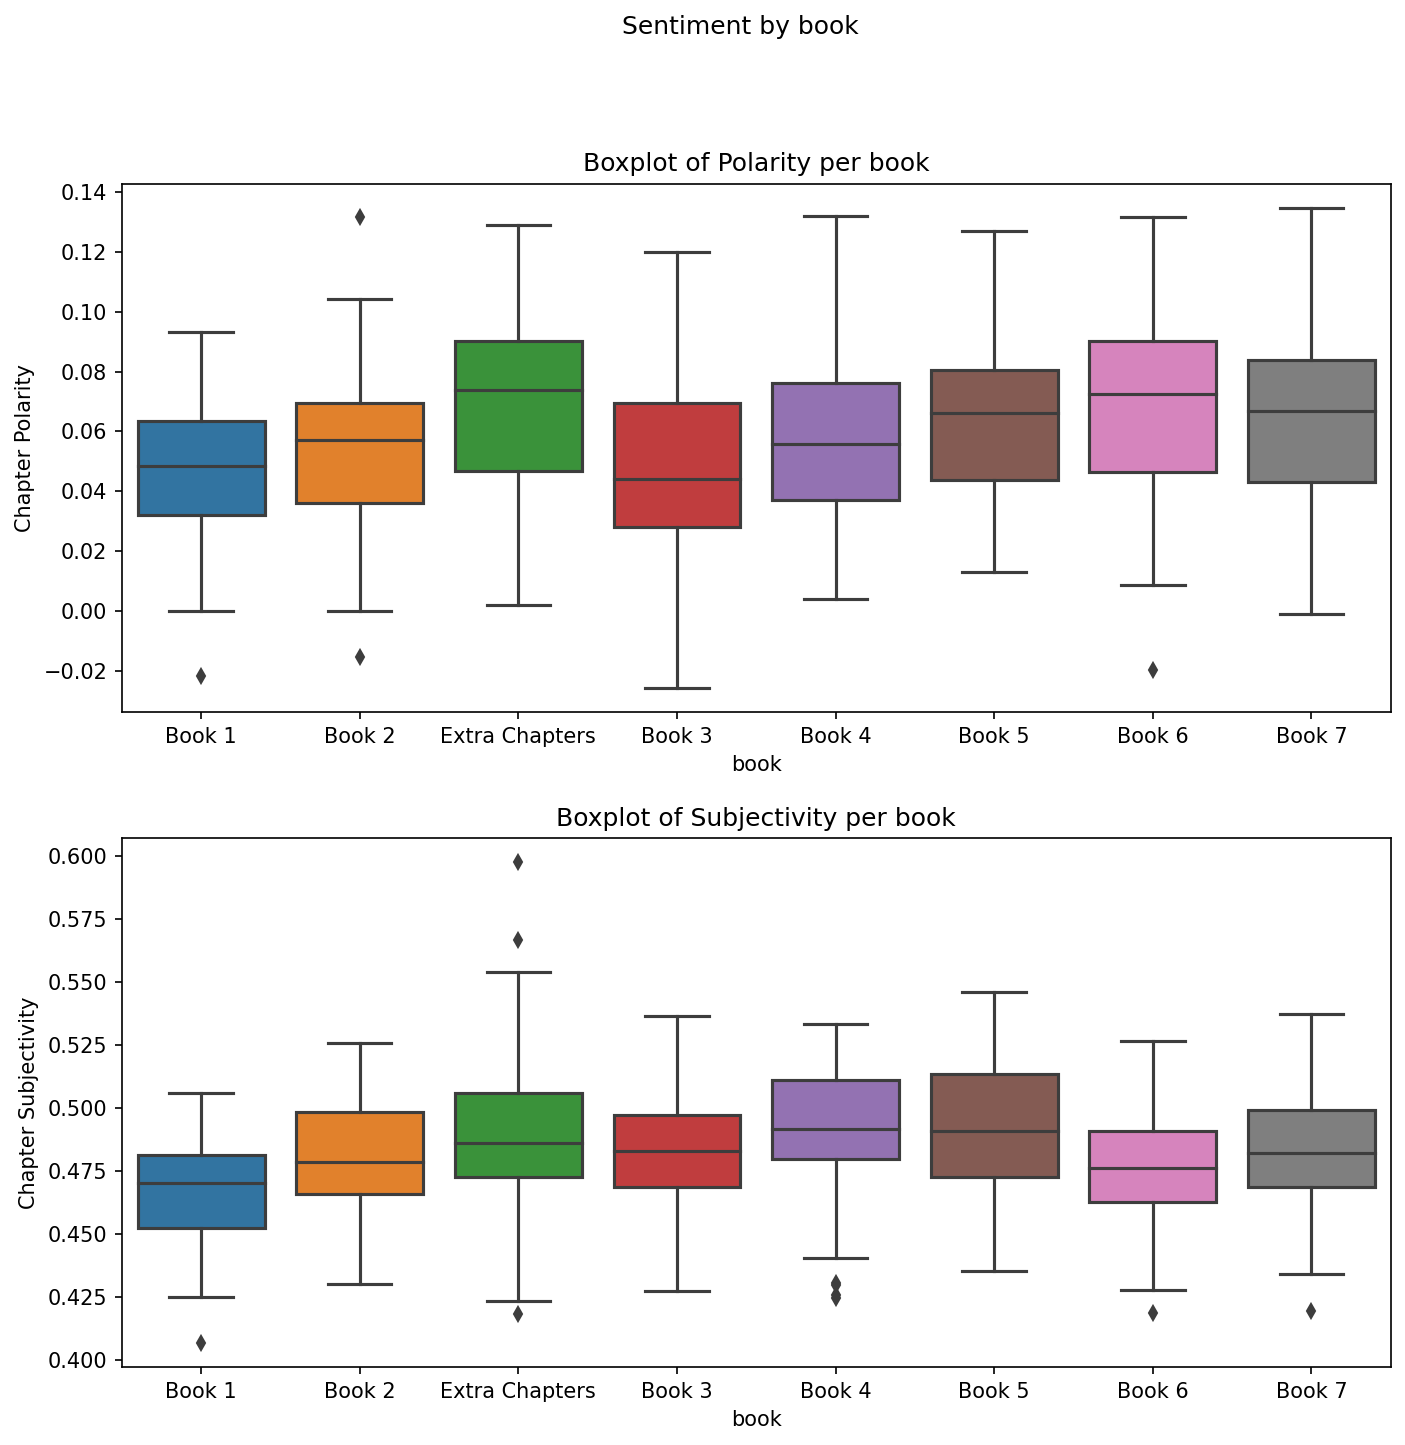

In [104]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
fig.suptitle("Sentiment by book")
fig.tight_layout(pad=4)

sns.boxplot(x="book",
               y="chapt_pol", 
               data=chapters,
               ax=ax[0])
ax[0].set_title("Boxplot of Polarity per book")
ax[0].set_ylabel("Chapter Polarity")

sns.boxplot(x="book",
               y="chapt_subj", 
               data=chapters,
               ax=ax[1])
ax[1].set_title("Boxplot of Subjectivity per book")
ax[1].set_ylabel("Chapter Subjectivity")

plt.show()

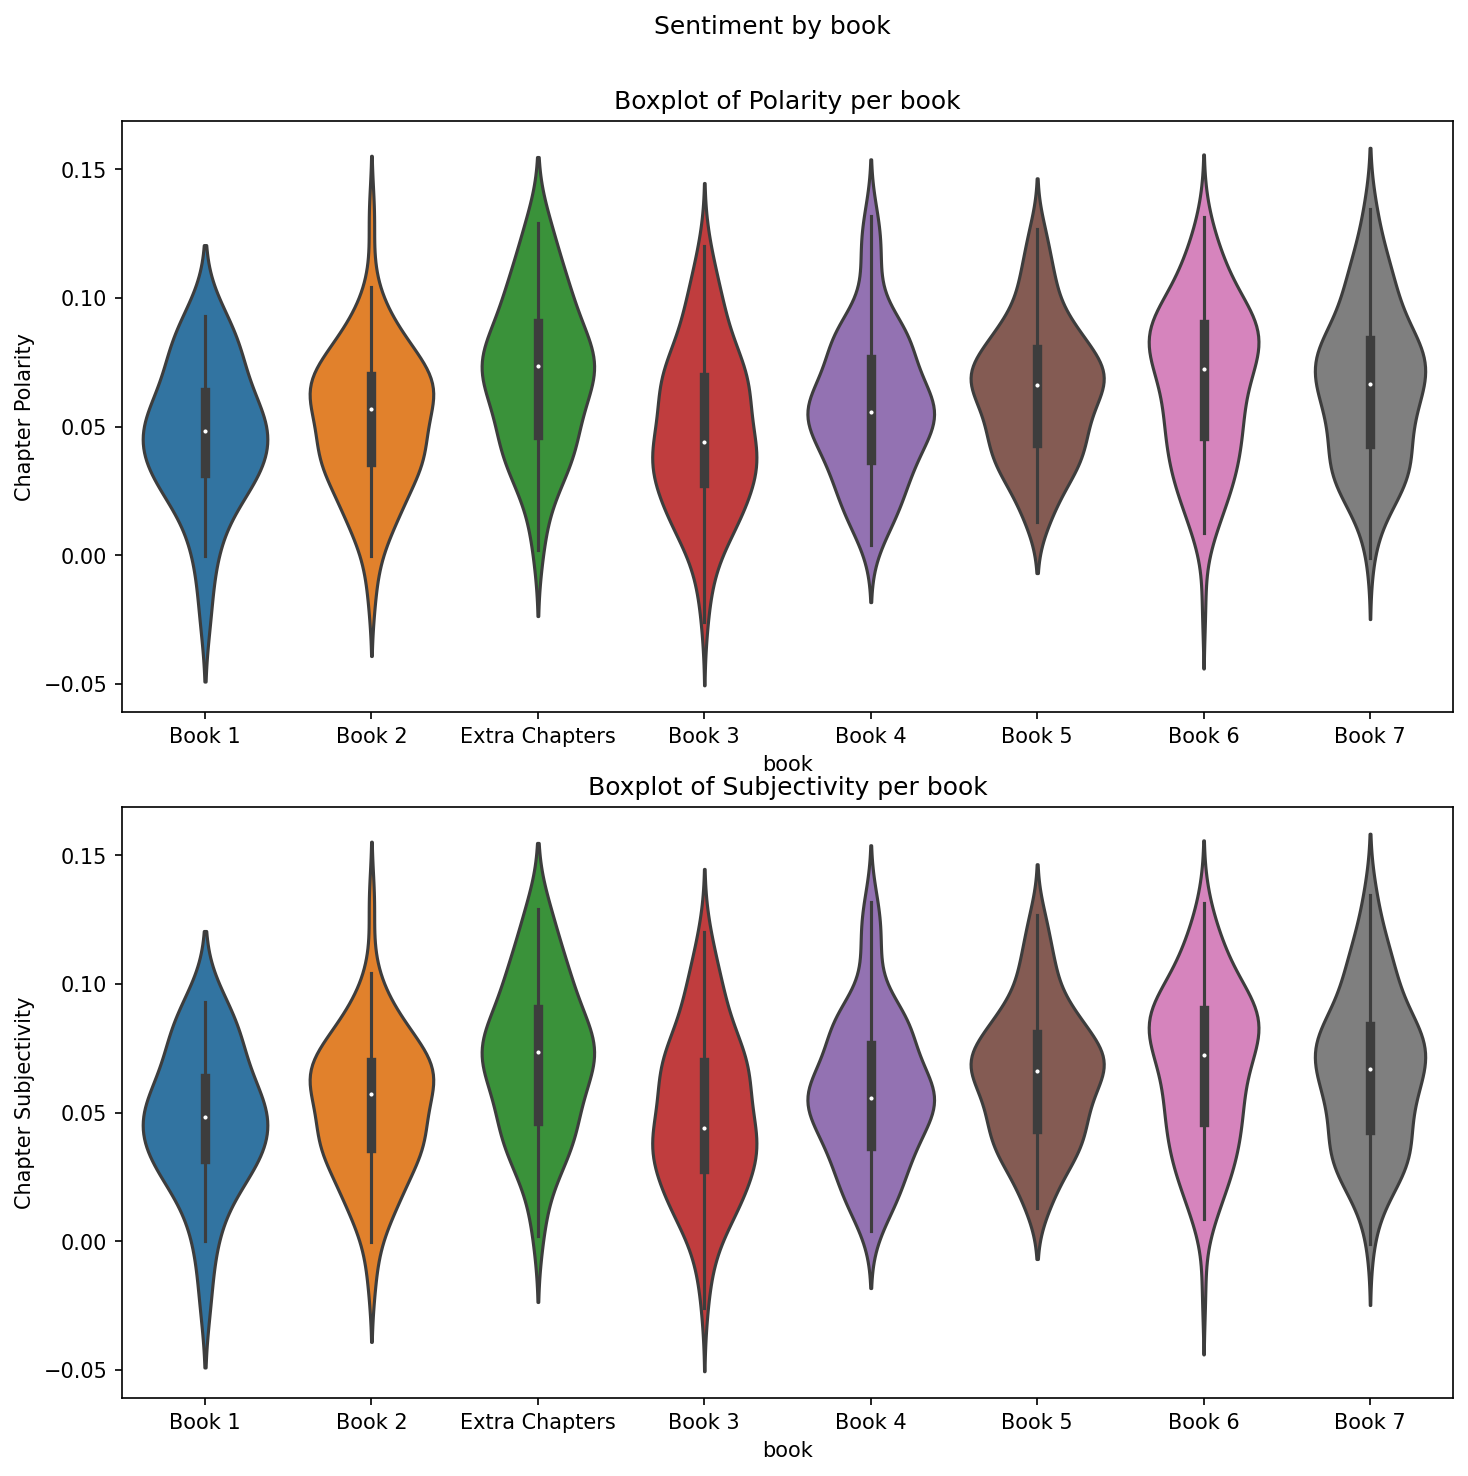

In [105]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
fig.suptitle("Sentiment by book")
fig.tight_layout(pad=2.5)

sns.violinplot(x="book",
               y="chapt_pol", 
               kind="violin", 
               data=chapters,
               ax=ax[0])
ax[0].set_title("Boxplot of Polarity per book")
ax[0].set_ylabel("Chapter Polarity")

sns.violinplot(x="book",
               y="chapt_pol", 
               kind="violin", 
               data=chapters,
               ax=ax[1])
ax[1].set_title("Boxplot of Subjectivity per book")
ax[1].set_ylabel("Chapter Subjectivity")

plt.show()

Overall, while we do see some movement in both polarity and subjectivity here, I'm inclined to say they're fairly stable over time. This isn't terribly surprising because of the size of the documents in question here. The weight of sentences and terms means that we will tend toward neutrality (a central tendency in a lot of respects).

#### Sentiment Over time

In [68]:
# cleaning up by converting the published and updated to datetime
chapters[["published"]] = chapters[["published"]].apply(pd.to_datetime)

chapters.sort_values(by="published", inplace=True)

chapt_ord = chapters["published"].apply(pd.Timestamp.toordinal)

lin_reg_pol = stats.linregress(chapt_ord, chapters["chapt_pol"])
lin_reg_subj = stats.linregress(chapt_ord, chapters["chapt_subj"])

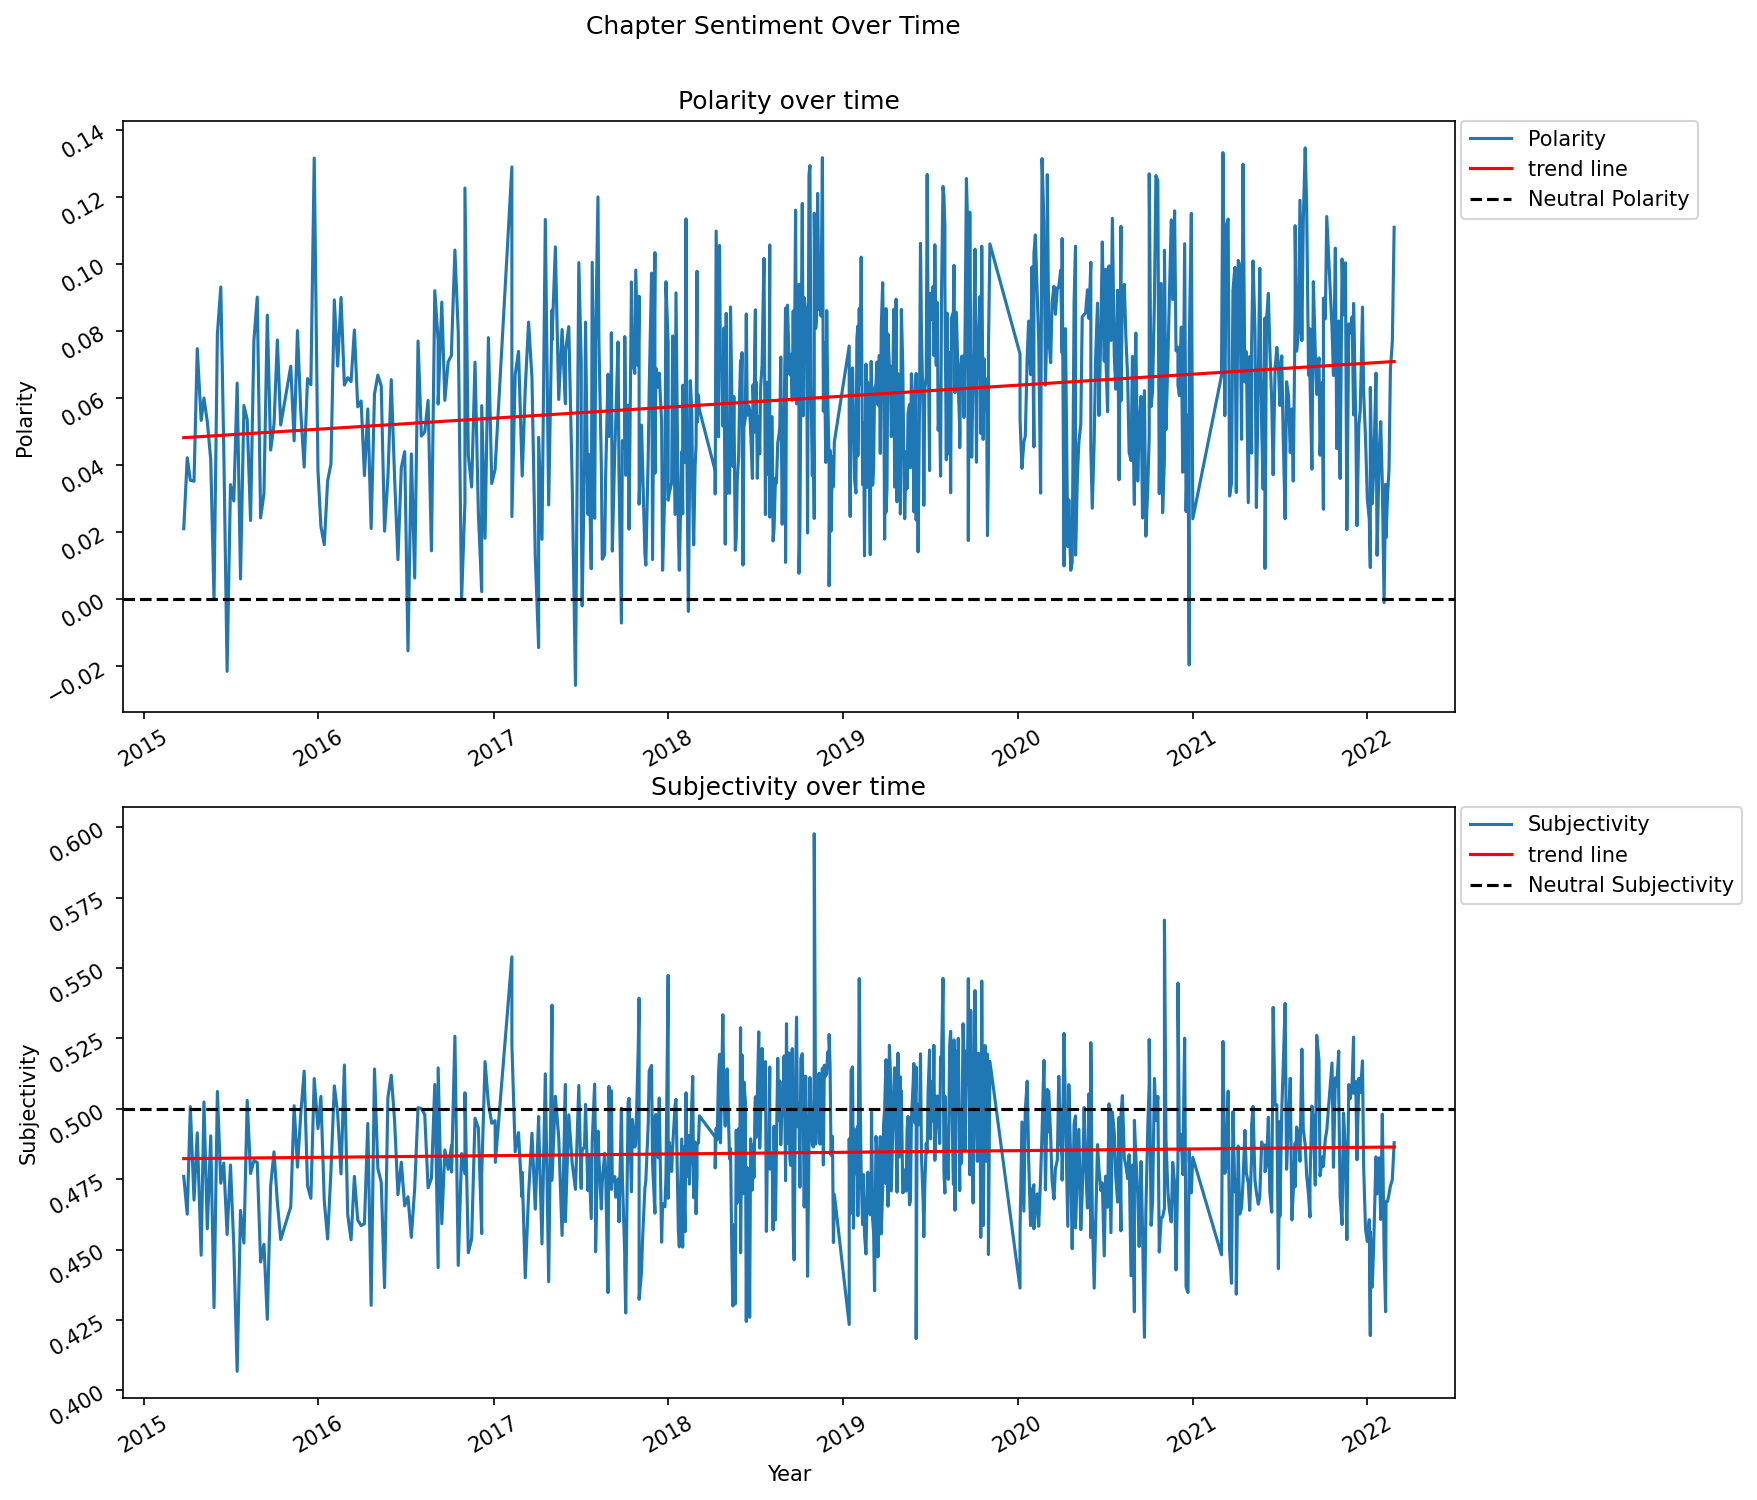

In [69]:
# finally, we want to go ahead and plot everything here. 

fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.suptitle("Chapter Sentiment Over Time")
fig.tight_layout(pad=2.5)

ax[0].plot(chapters["published"], chapters["chapt_pol"], label="Polarity") # our main trend
ax[0].plot(chapters["published"], lin_reg_pol.intercept + lin_reg_pol.slope*chapt_ord, 'r', label='trend line') # our trendline
ax[0].axhline(y=0.00, color='black', linestyle='--', label="Neutral Polarity")
ax[0].set_title("Polarity over time")
ax[0].tick_params(labelrotation=30)
ax[0].set_ylabel("Polarity")
ax[0].legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)

ax[1].plot(chapters["published"], chapters["chapt_subj"], label="Subjectivity") # our main trend
ax[1].plot(chapters["published"], lin_reg_subj.intercept + lin_reg_subj.slope*chapt_ord, 'r', label='trend line') # our trendline
ax[1].axhline(y=.5, color='black', linestyle='--', label="Neutral Subjectivity")
ax[1].set_title("Subjectivity over time")
ax[1].tick_params(labelrotation=30)
ax[1].set_ylabel("Subjectivity")
ax[1].legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)

plt.setp(ax[-1], xlabel='Year') # setting the x axis to only be on the bottom

plt.show()

Looking at the trend line here, the polarity of the chapters themselves would seem to be positive or at least more than neutral over time with only a few instances of negative polarity over time. The subjectivity in contrast would appear to be relatively stable in its trend even though it tends toward the objective rather than the subjective. Of course, this visualization is a tad messy to truly tease things out with so it might make sense for us to go ahead and approach this from a different angle.

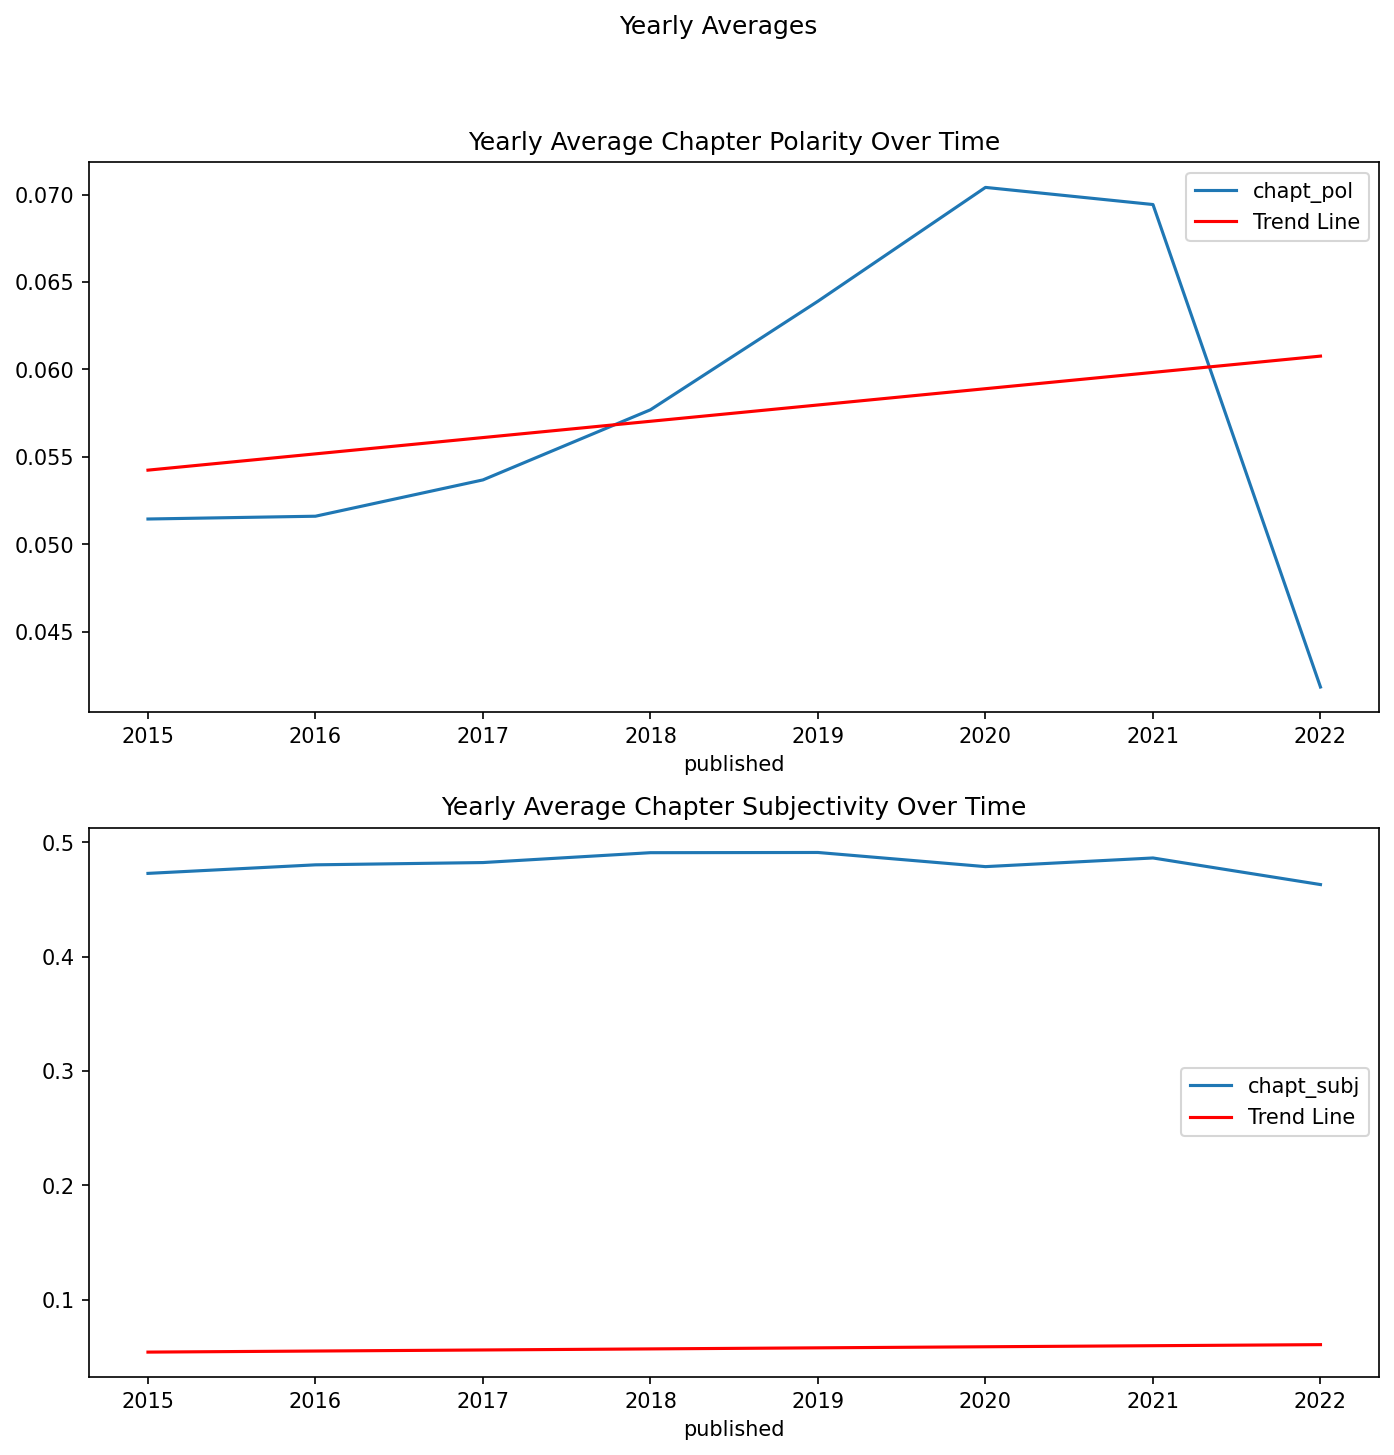

In [98]:
years_pol = chapters.groupby(chapters["published"].dt.year).agg({"chapt_pol": 'mean'}).index.values
year_avg_pol = chapters.groupby(chapters["published"].dt.year).agg({"chapt_pol": 'mean'})["chapt_pol"].values

year_regress_pol = stats.linregress(years_pol, year_avg_pol)

years_subj = chapters.groupby(chapters["published"].dt.year).agg({"chapt_subj": 'mean'}).index.values
year_avg_subj = chapters.groupby(chapters["published"].dt.year).agg({"chapt_subj": 'mean'})["chapt_subj"].values

year_regress_subj = stats.linregress(years_subj, year_avg_subj)

# plotting stuffs
fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.suptitle("Yearly Averages")
fig.tight_layout(pad=3.5)


chapters.groupby(chapters["published"].dt.year).agg({"chapt_pol": 'mean'}).plot(ax=ax[0]) # main plot
ax[0].plot(years, year_regress.intercept + year_regress.slope*years, 'r', label='Trend Line') # our trendline
ax[0].legend()
ax[0].set_title("Yearly Average Chapter Polarity Over Time")


chapters.groupby(chapters["published"].dt.year).agg({"chapt_subj": 'mean'}).plot(ax=ax[1]) # main plot
ax[1].plot(years, year_regress.intercept + year_regress.slope*years, 'r', label='Trend Line') # our trendline
ax[1].legend()
ax[1].set_title("Yearly Average Chapter Subjectivity Over Time")

plt.show()

We can see that the yearly averages for Chapter Polarity and Subjectivity are fairly stable over time. This isn't tierribly surprising because it would be quite unlikely for us to see any real changes from the baseline. This is because sentiment analysis isn't really suited for larger documents. As the length of a document increases, the more likely it is that it will tend to average out to neutral or near neutral. However, I thought it might prove worth the effort to explore this anyway. Overall, here we can see that the sentiment of the individual chapters is rather uninformative overall. We'll keep it anyway in case it manages to become a useful feature later on.

### Looking at trends in Comment Sentiment

#### Mean Sentiment per book

In [30]:
# equivalent to a join
comments_w_book = pd.merge(comments, chapters[["post_num","book"]], on="post_num")

In [59]:
# sorting the comments by book for sns
comments_w_book = comments_w_book.sort_values(by="book")

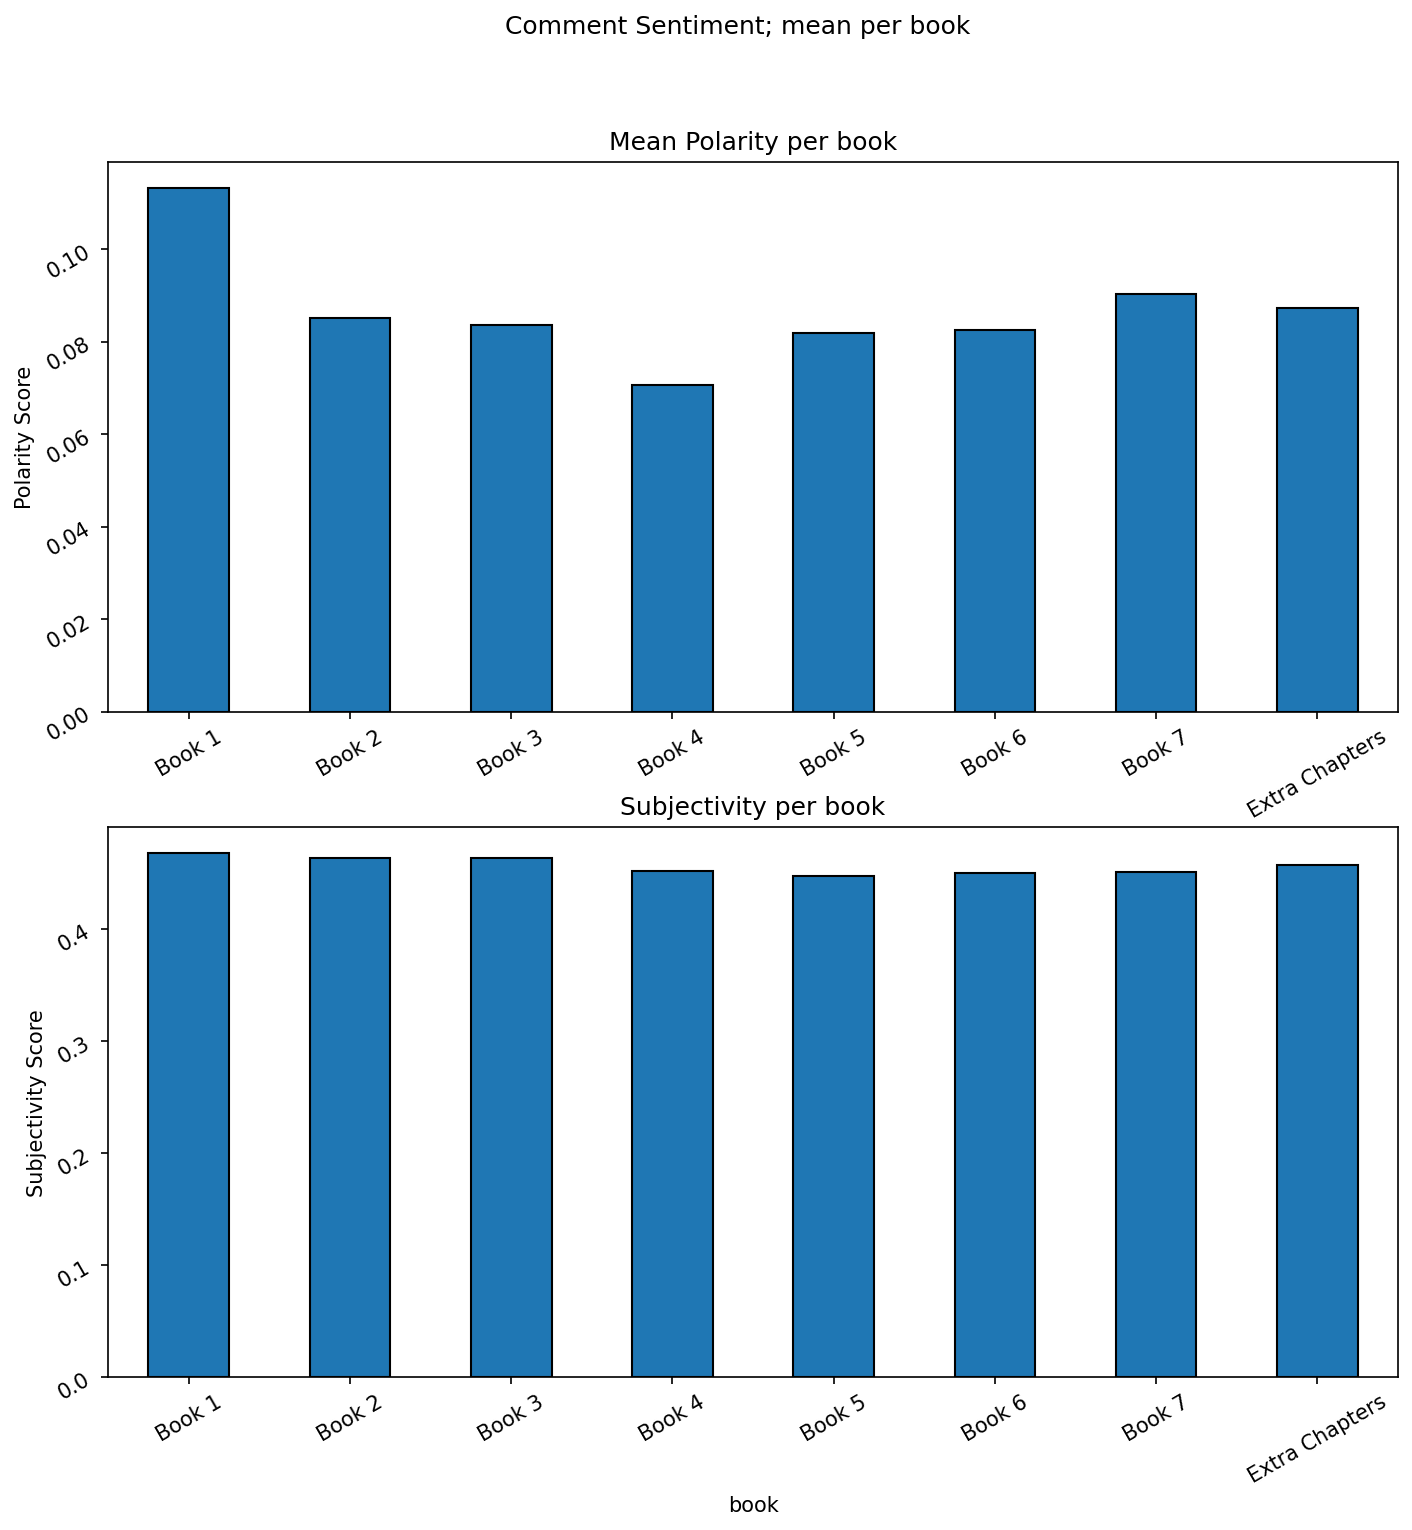

In [35]:

# this is an opportunity for us to go ahead and make some subplots
fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.suptitle("Comment Sentiment; mean per book")
fig.tight_layout(pad=3.5)


comments_w_book.groupby("book")["comment_pol"].mean().plot(kind="bar", edgecolor="black", ax=ax[0])
ax[0].set_title("Mean Polarity per book")
ax[0].tick_params(labelrotation=30)
ax[0].set_ylabel("Polarity Score")

comments_w_book.groupby("book")["comment_subj"].mean().plot(kind="bar", edgecolor="black", ax=ax[1])
ax[1].set_title("Subjectivity per book")
ax[1].tick_params(labelrotation=30)
ax[1].set_ylabel("Subjectivity Score")

plt.show()

In [ ]:
# i need to make subplots for everything here -> may be a bit larger than I'd like, but it's what's needed here...
# then I'll go ahead and compare them -> keep what I don't use for reference though for when I make my viz. ipynb.

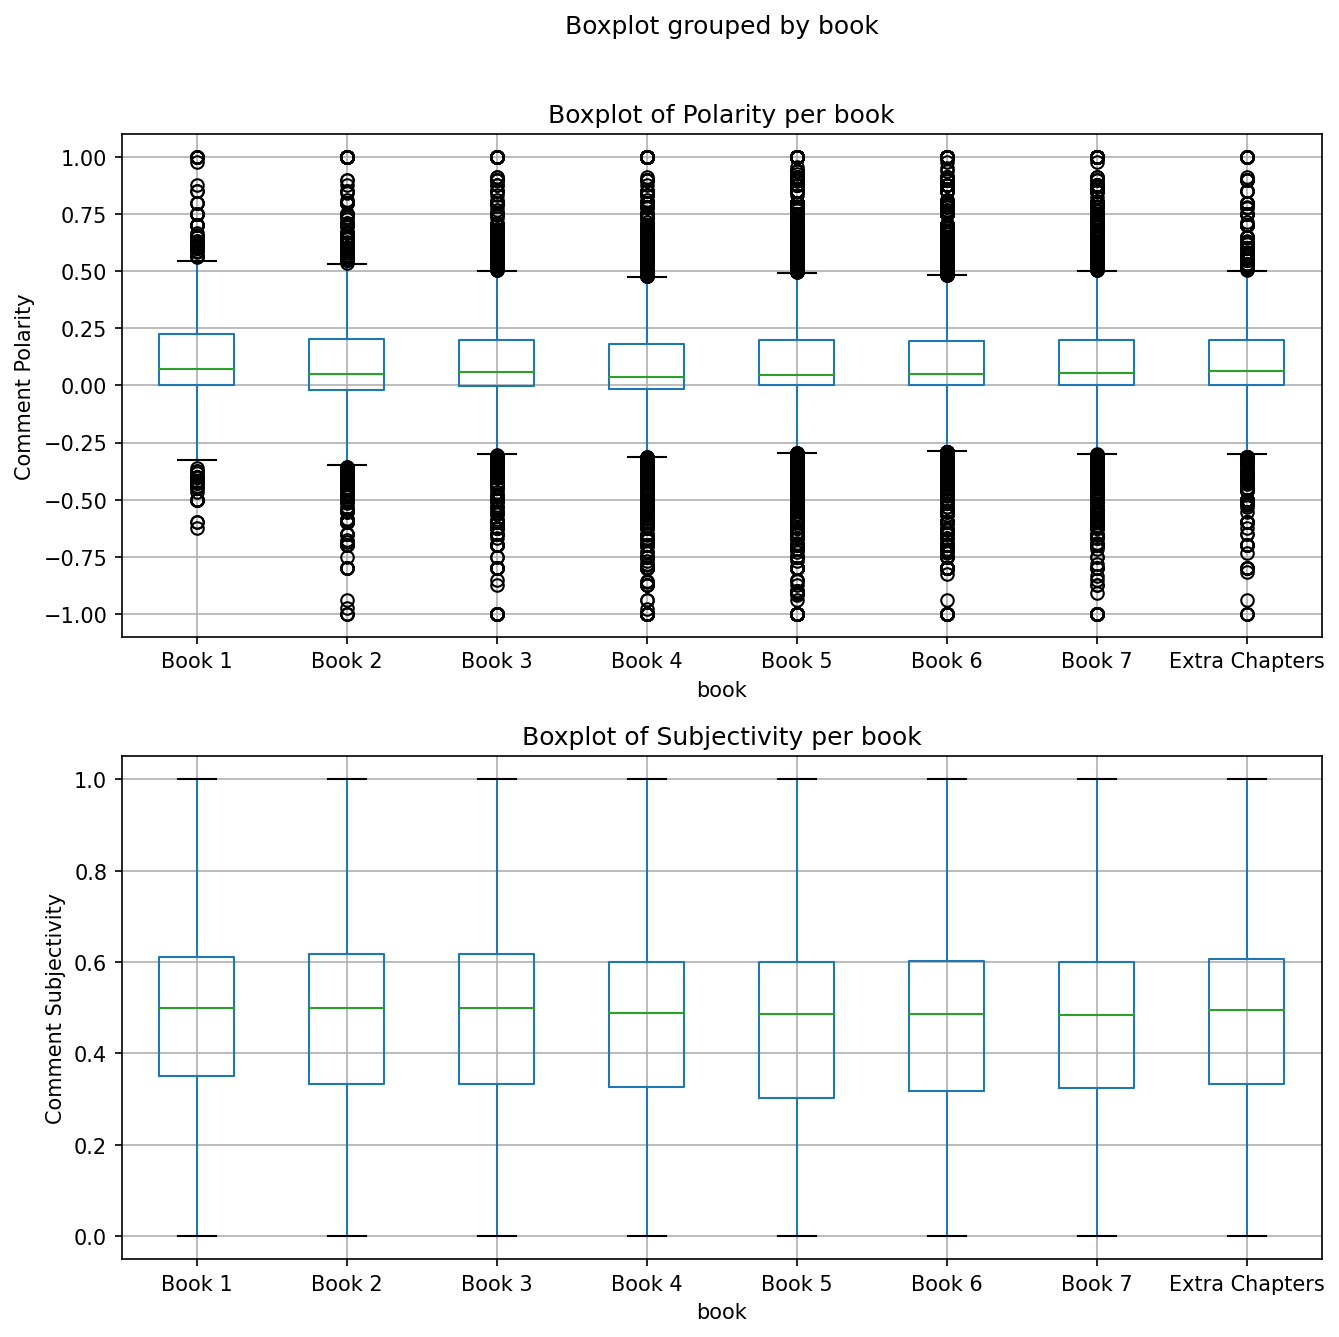

In [88]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
fig.suptitle("Sentiment by book")
fig.tight_layout(pad=4)

comments_w_book.boxplot(by="book",column="comment_pol", ax=ax[0])
ax[0].set_title("Boxplot of Polarity per book")
ax[0].set_ylabel("Comment Polarity")

comments_w_book.boxplot(by="book",column="comment_subj", ax=ax[1])
ax[1].set_title("Boxplot of Subjectivity per book")
ax[1].set_ylabel("Comment Subjectivity")

plt.show()

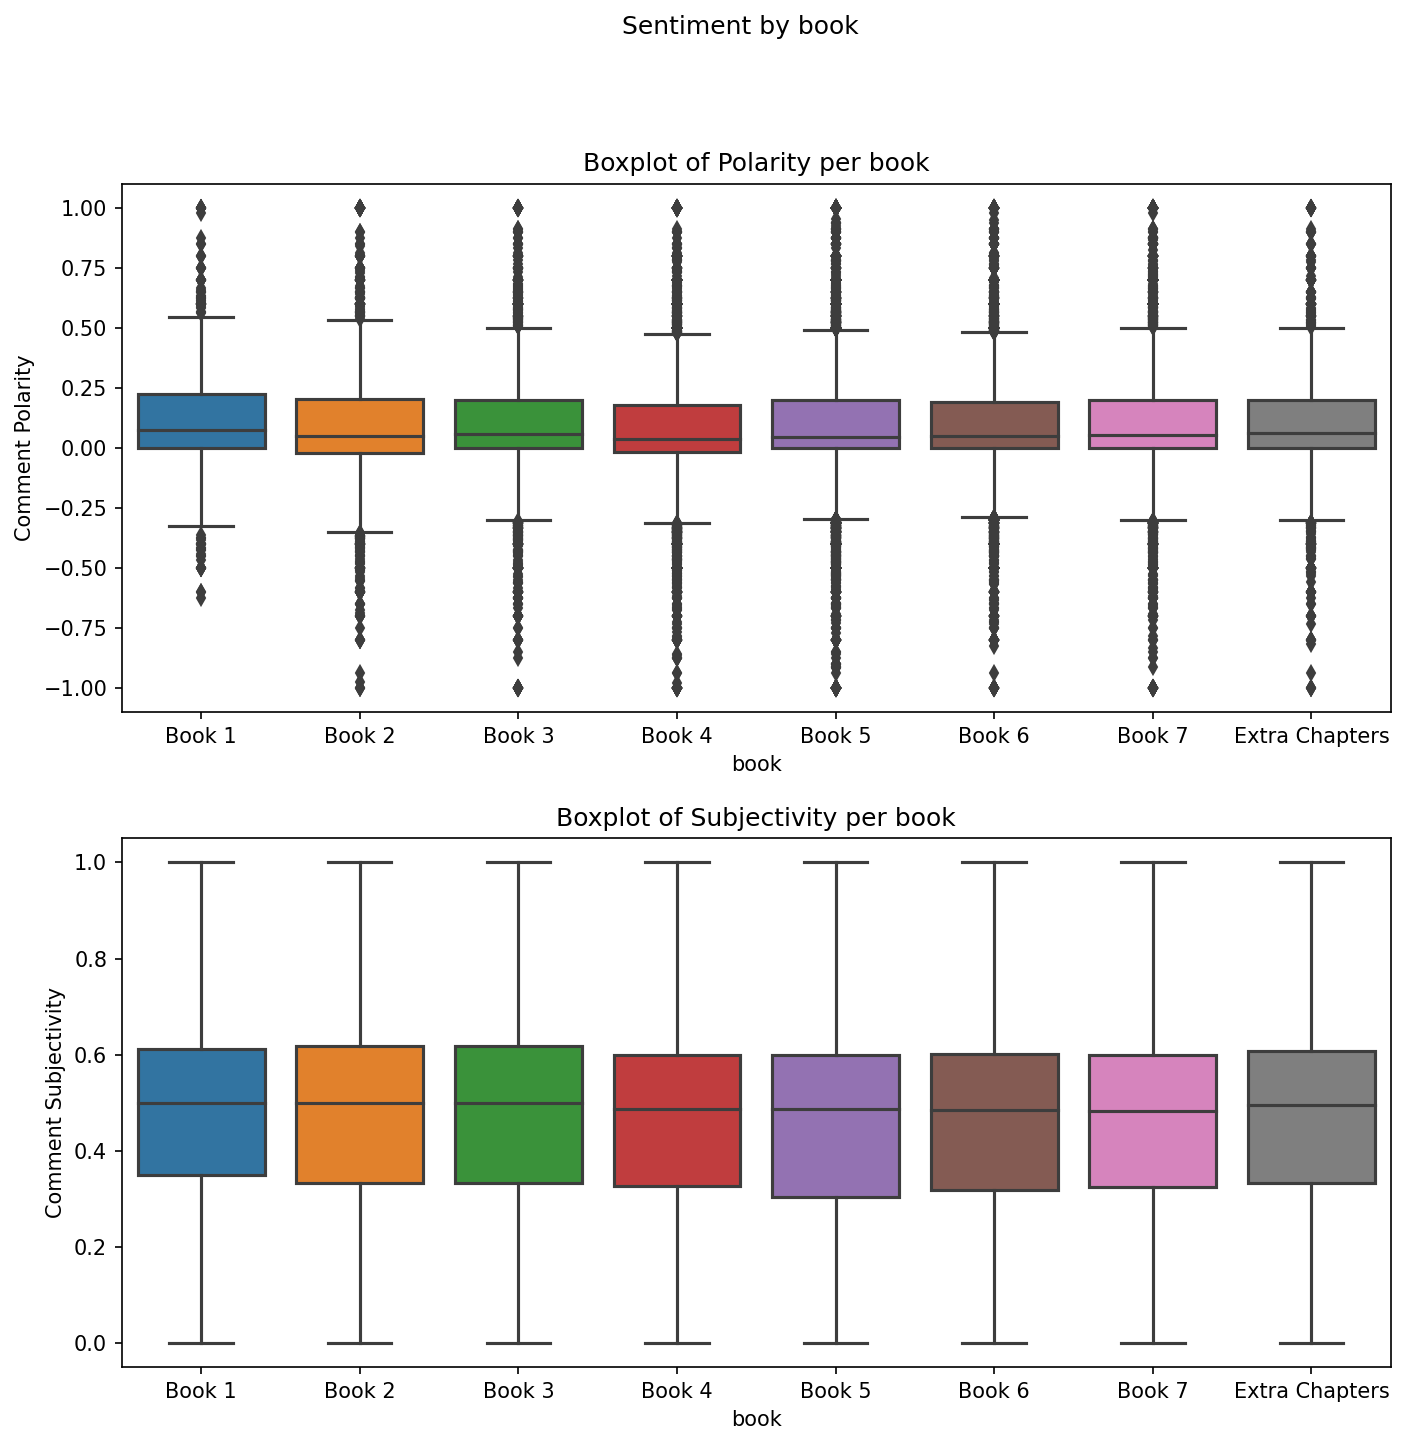

In [89]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
fig.suptitle("Sentiment by book")
fig.tight_layout(pad=4)

sns.boxplot(x="book",
               y="comment_pol", 
               data=comments_w_book,
               ax=ax[0])
ax[0].set_title("Boxplot of Polarity per book")
ax[0].set_ylabel("Comment Polarity")

sns.boxplot(x="book",
               y="comment_subj", 
               data=comments_w_book,
               ax=ax[1])
ax[1].set_title("Boxplot of Subjectivity per book")
ax[1].set_ylabel("Comment Subjectivity")

plt.show()

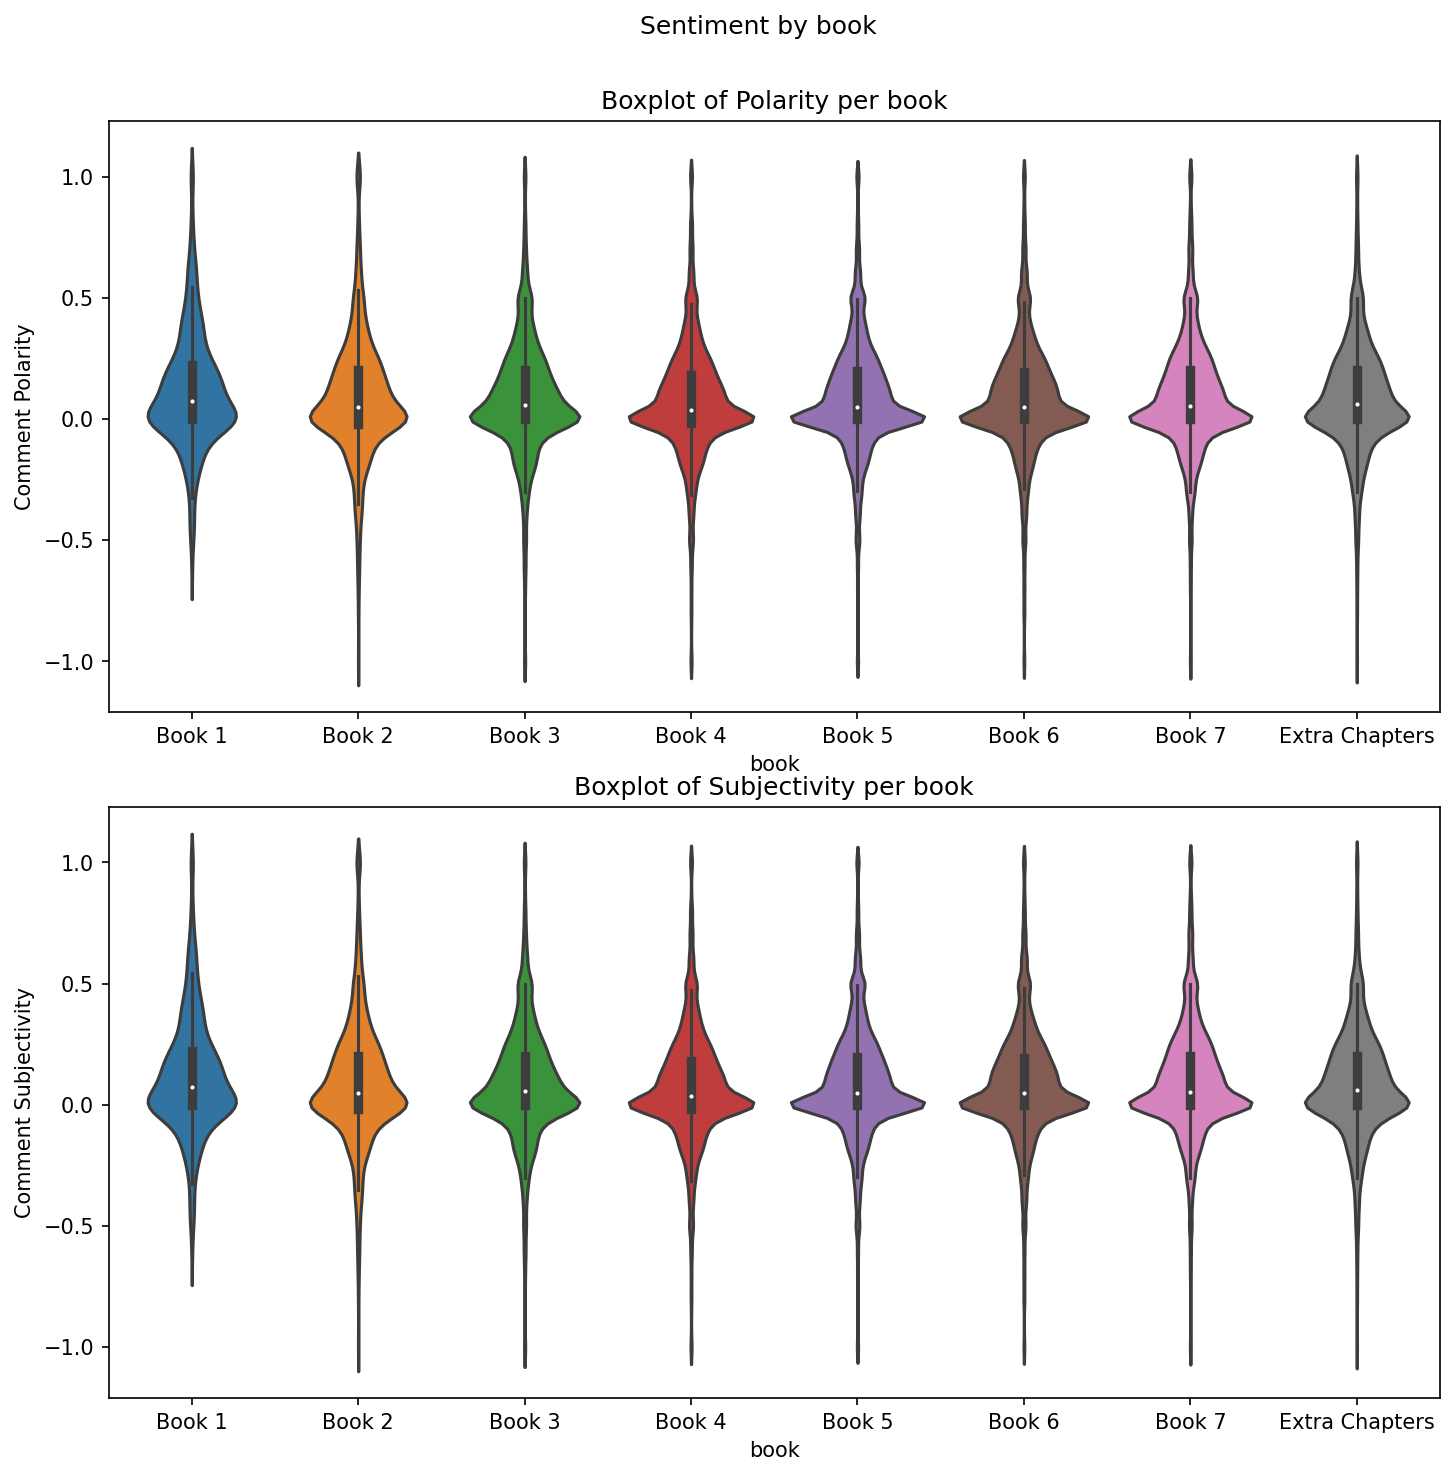

In [93]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
fig.suptitle("Sentiment by book")
fig.tight_layout(pad=2.5)

sns.violinplot(x="book",
               y="comment_pol", 
               kind="violin", 
               data=comments_w_book,
               ax=ax[0])
ax[0].set_title("Boxplot of Polarity per book")
ax[0].set_ylabel("Comment Polarity")

sns.violinplot(x="book",
               y="comment_pol", 
               kind="violin", 
               data=comments_w_book,
               ax=ax[1])
ax[1].set_title("Boxplot of Subjectivity per book")
ax[1].set_ylabel("Comment Subjectivity")

plt.show()

Like we saw with the sentiment for the chapters over time, when we are aggregating these values, we're going to see a tendency toward the center value. However, in this case, we can see that the polarity would seem to tend toward the positive rather than the negative. This shouldn't surprise us given what drives engagement here is likely to be someone liking it (though I would note that negative reactiosn also drive engagement though I suspect that is not a strategy employed by our esteemed author).

#### Sentiment Over time

In [13]:
# cleaning up by converting the published and updated to datetime
comments[["timestamp"]] = comments[["timestamp"]].apply(pd.to_datetime)

comments.sort_values(by="timestamp", inplace=True)

comment_ord = comments["timestamp"].apply(pd.Timestamp.toordinal)

lin_reg_pol = stats.linregress(comment_ord, comments["comment_pol"])
lin_reg_subj = stats.linregress(comment_ord, comments["comment_subj"])

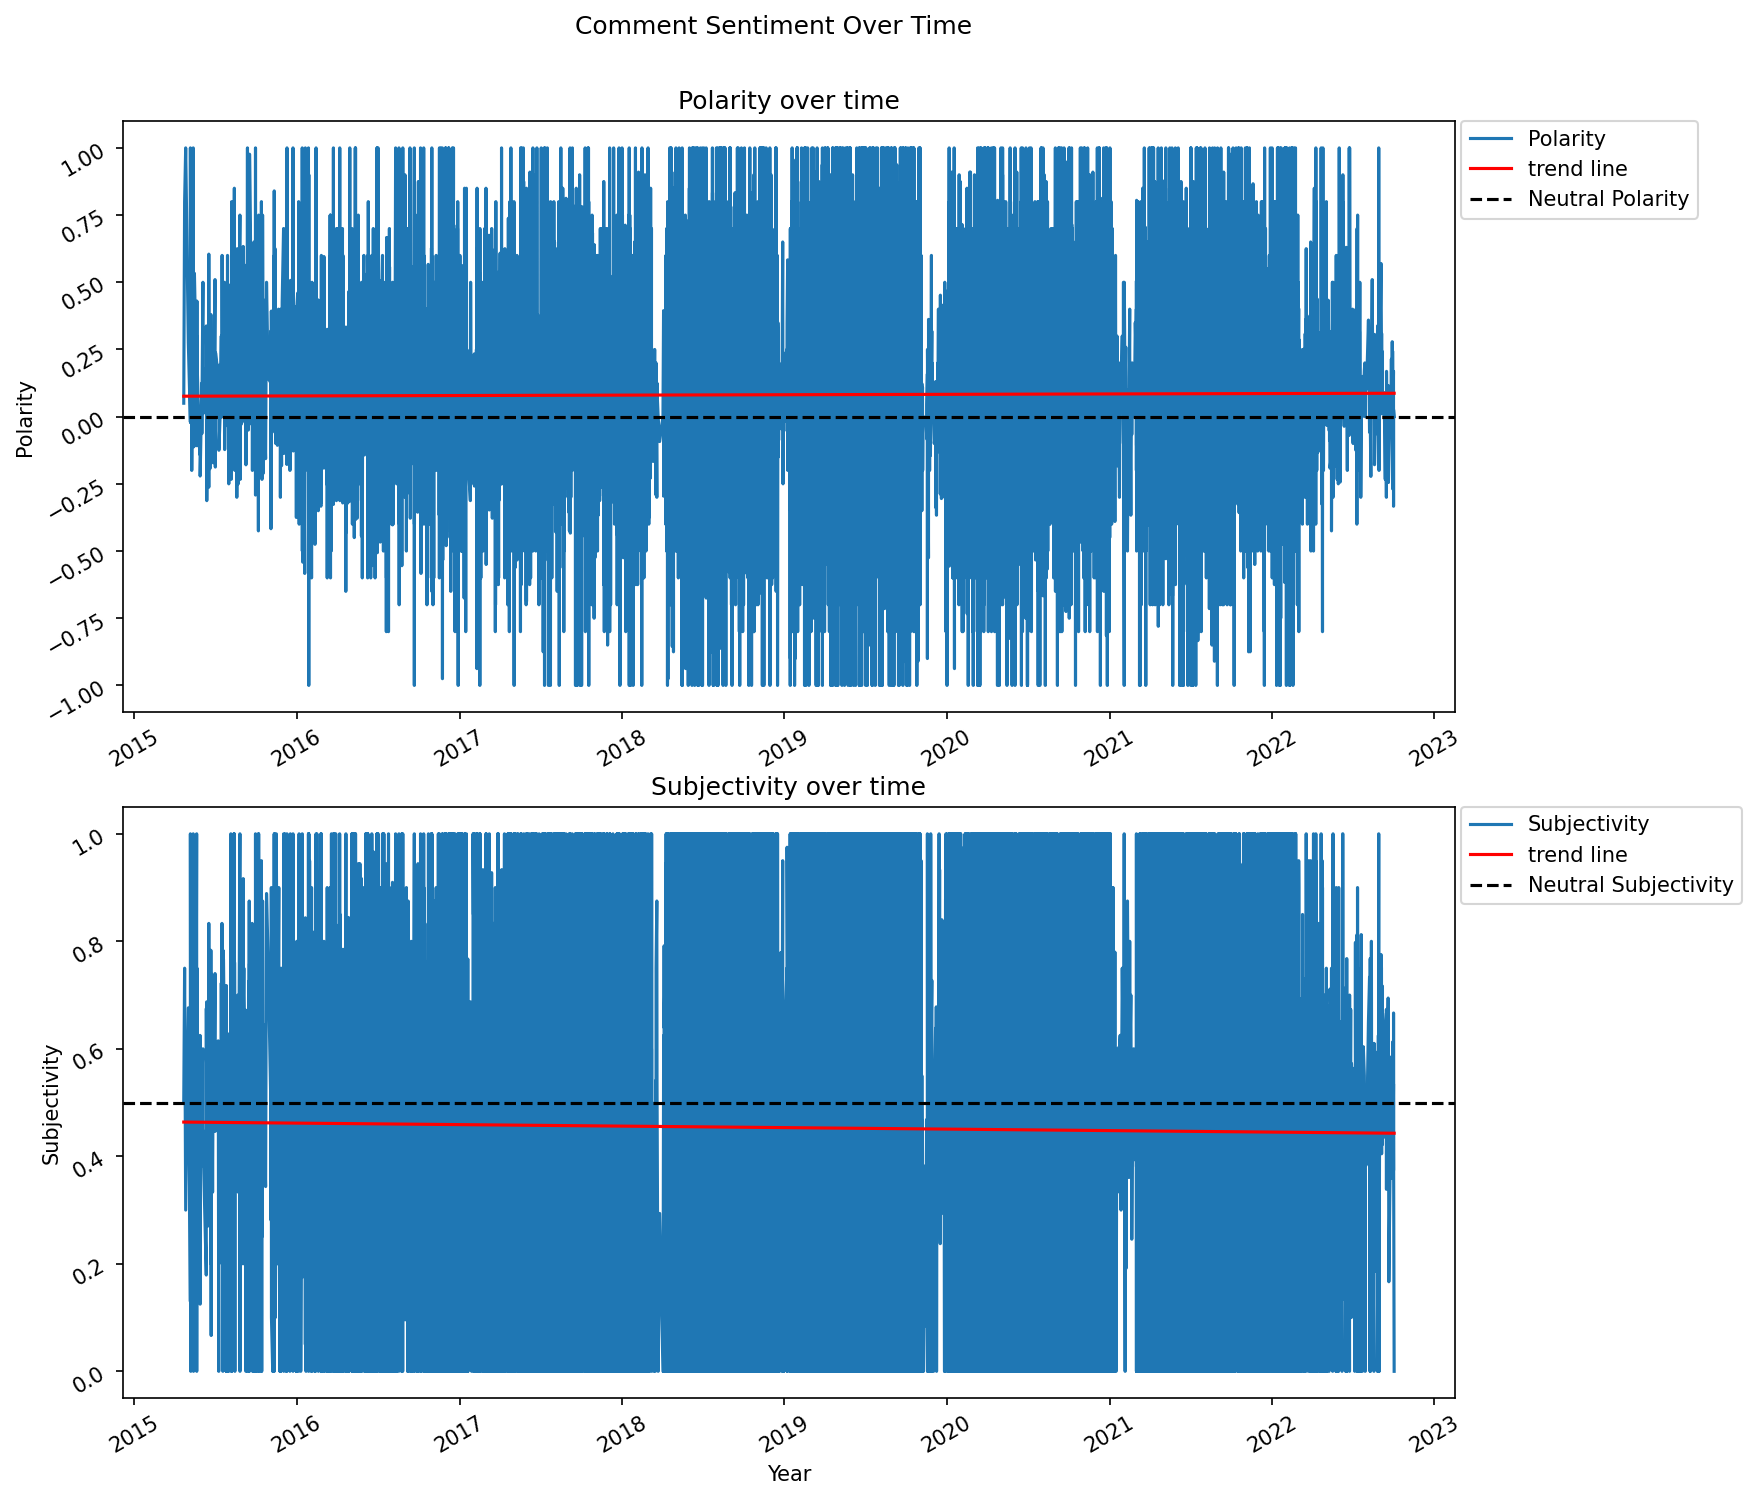

In [20]:
# finally, we want to go ahead and plot everything here. 

fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.suptitle("Comment Sentiment Over Time")
fig.tight_layout(pad=2.5)

ax[0].plot(comments["timestamp"], comments["comment_pol"], label="Polarity") # our main trend
ax[0].plot(comments["timestamp"], lin_reg_pol.intercept + lin_reg_pol.slope*comment_ord, 'r', label='trend line') # our trendline
ax[0].axhline(y=0.00, color='black', linestyle='--', label="Neutral Polarity")
ax[0].set_title("Polarity over time")
ax[0].tick_params(labelrotation=30)
ax[0].set_ylabel("Polarity")
ax[0].legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)

ax[1].plot(comments["timestamp"], comments["comment_subj"], label="Subjectivity") # our main trend
ax[1].plot(comments["timestamp"], lin_reg_subj.intercept + lin_reg_subj.slope*comment_ord, 'r', label='trend line') # our trendline
ax[1].axhline(y=.5, color='black', linestyle='--', label="Neutral Subjectivity")
ax[1].set_title("Subjectivity over time")
ax[1].tick_params(labelrotation=30)
ax[1].set_ylabel("Subjectivity")
ax[1].legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)

plt.setp(ax[-1], xlabel='Year') # setting the x axis to only be on the bottom

plt.show()

Overall, there are just too many data points for us to be able to see anything here. This is a reminder that sometimes we *have* to aggreagte to make meaning out of data. We *can* see that the comments seem to be more less stable in their polarity (0 is neutral polarity) but that they are becoming less subjective over time (0.0 is objective 1.0 is subjective). Of course, to get a better idea of what's going on here, it would behoove us to aggregate this. 

#### Yearly Sentiment over time

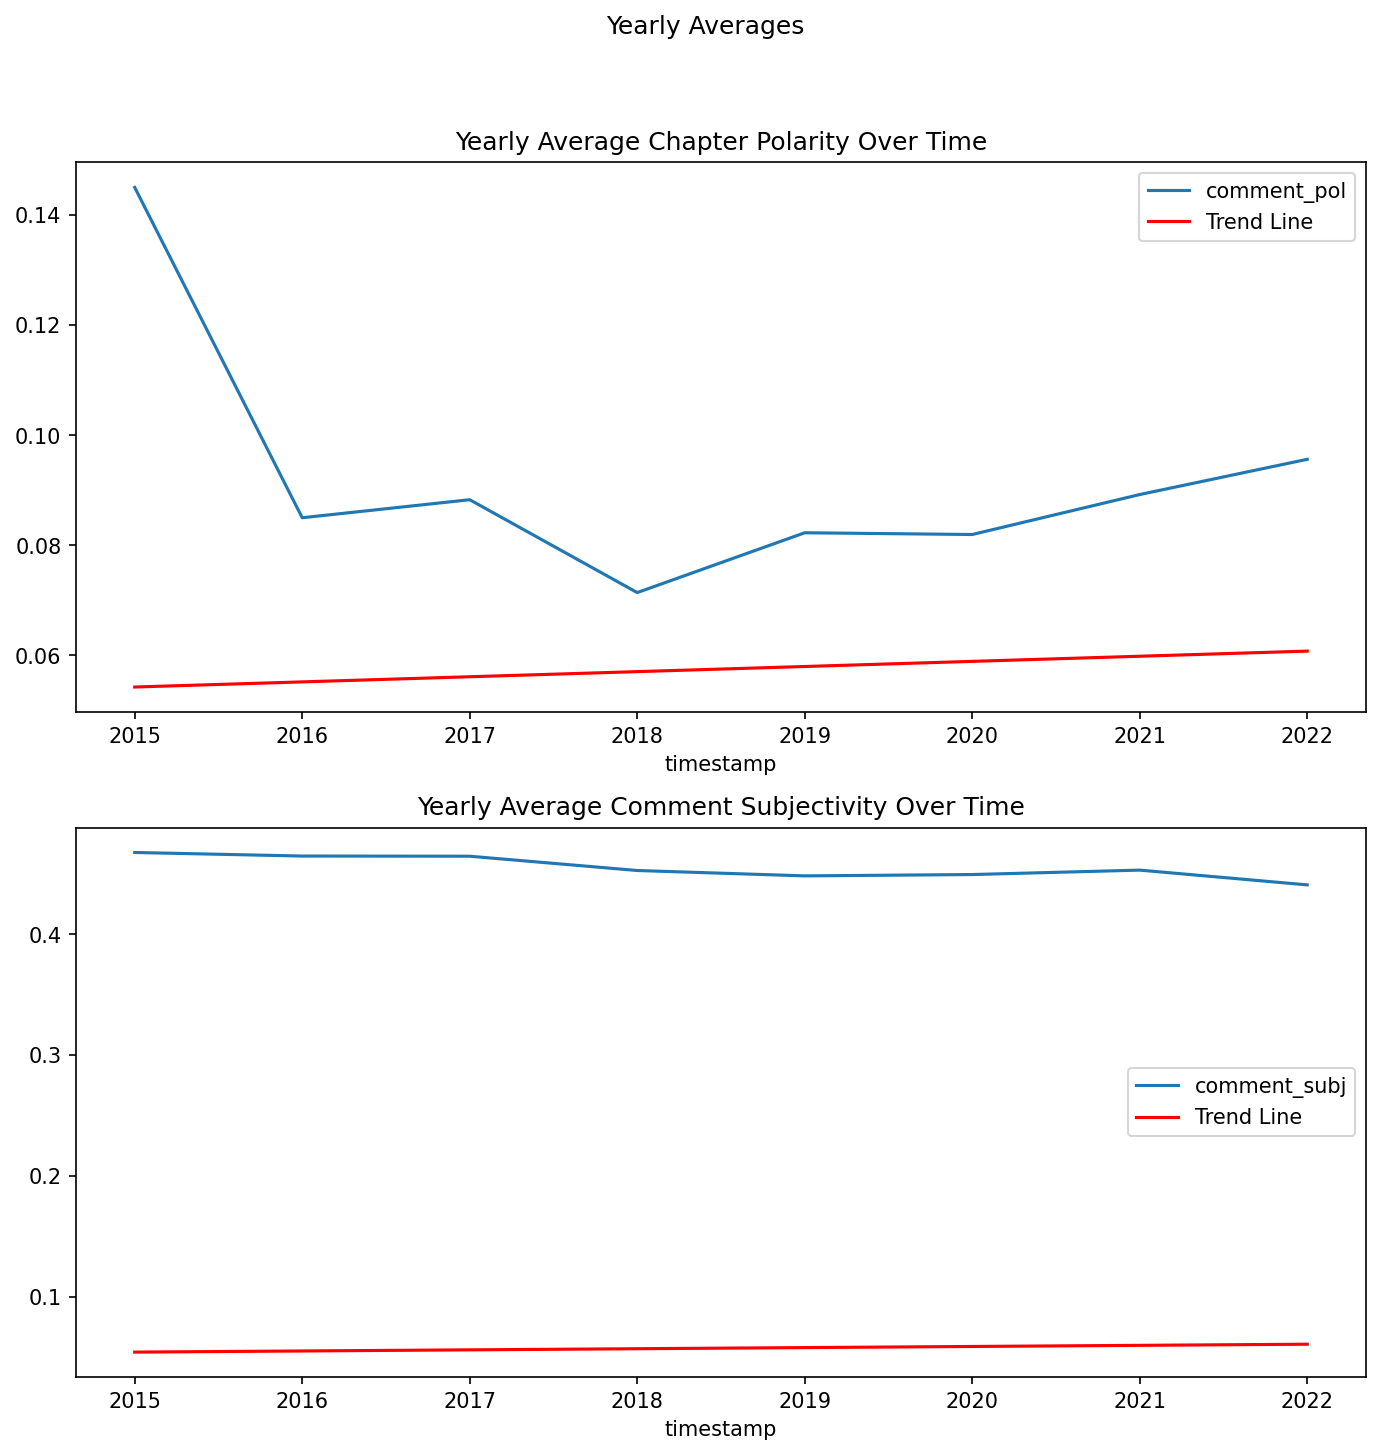

In [100]:
years_pol = comments.groupby(comments["timestamp"].dt.year).agg({"comment_pol": 'mean'}).index.values
year_avg_pol = comments.groupby(comments["timestamp"].dt.year).agg({"comment_pol": 'mean'})["comment_pol"].values

year_regress_pol = stats.linregress(years_pol, year_avg_pol)

years_subj = comments.groupby(comments["timestamp"].dt.year).agg({"comment_subj": 'mean'}).index.values
year_avg_subj = comments.groupby(comments["timestamp"].dt.year).agg({"comment_subj": 'mean'})["comment_subj"].values

year_regress_subj = stats.linregress(years_subj, year_avg_subj)

# plotting stuffs
fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.suptitle("Yearly Averages")
fig.tight_layout(pad=3.5)


comments.groupby(comments["timestamp"].dt.year).agg({"comment_pol": 'mean'}).plot(ax=ax[0]) # main plot
ax[0].plot(years, year_regress.intercept + year_regress.slope*years, 'r', label='Trend Line') # our trendline
ax[0].legend()
ax[0].set_title("Yearly Average Chapter Polarity Over Time")


comments.groupby(comments["timestamp"].dt.year).agg({"comment_subj": 'mean'}).plot(ax=ax[1]) # main plot
ax[1].plot(years, year_regress.intercept + year_regress.slope*years, 'r', label='Trend Line') # our trendline
ax[1].legend()
ax[1].set_title("Yearly Average Comment Subjectivity Over Time")

plt.show()

Looking at our trends here, we can see that the comments are fairly stable over time in terms of subjectivity and polarity. Because while we do see some movement in polarity, the amount it changes is rather minimal. This is likely the result of the weight of numbers averaging out to something near neutral. This is an issue with sentiment classification and larger texts and it wouldn't surprise me to see a similar thing happening here with the sheer number of comments.